In [6]:
import time
import sys
import multiprocessing
import copy
from collections import deque
from pprint import pprint
import os

import matplotlib.pyplot as plt
from IPython import display
%matplotlib notebook

import gym
from gym import spaces
import numpy as np
import tensorflow as tf

from stable_baselines import bench, logger
from stable_baselines.common import set_global_seeds
from stable_baselines.common import explained_variance, ActorCriticRLModel, tf_util, SetVerbosity, TensorboardWriter
from stable_baselines.common.runners import AbstractEnvRunner
from stable_baselines.common.policies import LstmPolicy, ActorCriticPolicy
from stable_baselines.a2c.utils import total_episode_reward_logger
from stable_baselines.ppo2 import PPO2
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines.common.vec_env.vec_normalize import VecNormalize
from stable_baselines.results_plotter import load_results, ts2xy

from pathlib import Path
home = str(Path.home())

In [7]:
class PPO2_Mod(ActorCriticRLModel):
    """
    Proximal Policy Optimization algorithm (GPU version).
    Paper: https://arxiv.org/abs/1707.06347

    :param policy: (ActorCriticPolicy or str) The policy model to use (MlpPolicy, CnnPolicy, CnnLstmPolicy, ...)
    :param env: (Gym environment or str) The environment to learn from (if registered in Gym, can be str)
    :param gamma: (float) Discount factor
    :param n_steps: (int) The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param ent_coef: (float) Entropy coefficient for the loss caculation
    :param learning_rate: (float or callable) The learning rate, it can be a function
    :param vf_coef: (float) Value function coefficient for the loss calculation
    :param max_grad_norm: (float) The maximum value for the gradient clipping
    :param lam: (float) Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param nminibatches: (int) Number of training minibatches per update. For recurrent policies,
        the number of environments run in parallel should be a multiple of nminibatches.
    :param noptepochs: (int) Number of epoch when optimizing the surrogate
    :param cliprange: (float or callable) Clipping parameter, it can be a function
    :param verbose: (int) the verbosity level: 0 none, 1 training information, 2 tensorflow debug
    :param tensorboard_log: (str) the log location for tensorboard (if None, no logging)
    :param _init_setup_model: (bool) Whether or not to build the network at the creation of the instance
    """

    def __init__(self, policy, env, gamma=0.99, n_steps=128, ent_coef=0.01, learning_rate=2.5e-4, vf_coef=0.5,
                 max_grad_norm=0.5, lam=0.95, nminibatches=4, noptepochs=4, cliprange=0.2, verbose=0,
                 tensorboard_log=None, _init_setup_model=True):

        super(PPO2_Mod, self).__init__(policy=policy, env=env, verbose=verbose, requires_vec_env=True,
                                   _init_setup_model=_init_setup_model)

        if isinstance(learning_rate, float):
            learning_rate = constfn(learning_rate)
        else:
            assert callable(learning_rate)
        if isinstance(cliprange, float):
            cliprange = constfn(cliprange)
        else:
            assert callable(cliprange)

        self.learning_rate = learning_rate
        self.cliprange = cliprange
        self.n_steps = n_steps
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.max_grad_norm = max_grad_norm
        self.gamma = gamma
        self.lam = lam
        self.nminibatches = nminibatches
        self.noptepochs = noptepochs
        self.tensorboard_log = tensorboard_log

        self.graph = None
        self.sess = None
        self.action_ph = None
        self.advs_ph = None
        self.rewards_ph = None
        self.old_neglog_pac_ph = None
        self.old_vpred_ph = None
        self.learning_rate_ph = None
        self.clip_range_ph = None
        self.entropy = None
        self.vf_loss = None
        self.pg_loss = None
        self.approxkl = None
        self.clipfrac = None
        self.params = None
        self._train = None
        self.loss_names = None
        self.train_model = None
        self.act_model = None
        self.step = None
        self.proba_step = None
        self.value = None
        self.initial_state = None
        self.n_batch = None
        self.summary = None
        self.episode_reward = None

        if _init_setup_model:
            self.setup_model()

    def setup_model(self):
        with SetVerbosity(self.verbose):

            assert issubclass(self.policy, ActorCriticPolicy), "Error: the input policy for the PPO2 model must be " \
                                                               "an instance of common.policies.ActorCriticPolicy."

            self.n_batch = self.n_envs * self.n_steps

            n_cpu = multiprocessing.cpu_count()
            if sys.platform == 'darwin':
                n_cpu //= 2

            self.graph = tf.Graph()
            with self.graph.as_default():
                self.sess = tf_util.make_session(num_cpu=n_cpu, graph=self.graph)

                n_batch_step = None
                n_batch_train = None
                if issubclass(self.policy, LstmPolicy):
                    assert self.n_envs % self.nminibatches == 0, "For recurrent policies, "\
                        "the number of environments run in parallel should be a multiple of nminibatches."
                    n_batch_step = self.n_envs
                    n_batch_train = self.n_batch // self.nminibatches

                act_model = self.policy(self.sess, self.observation_space, self.action_space, self.n_envs, 1,
                                        n_batch_step, reuse=False)
                with tf.variable_scope("train_model", reuse=True,
                                       custom_getter=tf_util.outer_scope_getter("train_model")):
                    train_model = self.policy(self.sess, self.observation_space, self.action_space,
                                              self.n_envs // self.nminibatches, self.n_steps, n_batch_train,
                                              reuse=True)

                with tf.variable_scope("loss", reuse=False):
                    self.action_ph = train_model.pdtype.sample_placeholder([None], name="action_ph")
                    self.advs_ph = tf.placeholder(tf.float32, [None], name="advs_ph")
                    self.rewards_ph = tf.placeholder(tf.float32, [None], name="rewards_ph")
                    self.old_neglog_pac_ph = tf.placeholder(tf.float32, [None], name="old_neglog_pac_ph")
                    self.old_vpred_ph = tf.placeholder(tf.float32, [None], name="old_vpred_ph")
                    self.learning_rate_ph = tf.placeholder(tf.float32, [], name="learning_rate_ph")
                    self.clip_range_ph = tf.placeholder(tf.float32, [], name="clip_range_ph")

                    neglogpac = train_model.proba_distribution.neglogp(self.action_ph)
                    self.entropy = tf.reduce_mean(train_model.proba_distribution.entropy())

                    vpred = train_model._value
                    vpredclipped = self.old_vpred_ph + tf.clip_by_value(
                        train_model._value - self.old_vpred_ph, - self.clip_range_ph, self.clip_range_ph)
                    vf_losses1 = tf.square(vpred - self.rewards_ph)
                    vf_losses2 = tf.square(vpredclipped - self.rewards_ph)
                    self.vf_loss = .5 * tf.reduce_mean(tf.maximum(vf_losses1, vf_losses2))
                    ratio = tf.exp(self.old_neglog_pac_ph - neglogpac)
                    pg_losses = -self.advs_ph * ratio
                    pg_losses2 = -self.advs_ph * tf.clip_by_value(ratio, 1.0 - self.clip_range_ph, 1.0 +
                                                                  self.clip_range_ph)
                    self.pg_loss = tf.reduce_mean(tf.maximum(pg_losses, pg_losses2))
                    self.approxkl = .5 * tf.reduce_mean(tf.square(neglogpac - self.old_neglog_pac_ph))
                    self.clipfrac = tf.reduce_mean(tf.to_float(tf.greater(tf.abs(ratio - 1.0), self.clip_range_ph)))
                    loss = self.pg_loss - self.entropy * self.ent_coef + self.vf_loss * self.vf_coef

                    tf.summary.scalar('entropy_loss', self.entropy)
                    tf.summary.scalar('policy_gradient_loss', self.pg_loss)
                    tf.summary.scalar('value_function_loss', self.vf_loss)
                    tf.summary.scalar('approximate_kullback-leiber', self.approxkl)
                    tf.summary.scalar('clip_factor', self.clipfrac)
                    tf.summary.scalar('loss', loss)

                    with tf.variable_scope('model'):
                        self.params = tf.trainable_variables()
                    grads = tf.gradients(loss, self.params)
                    if self.max_grad_norm is not None:
                        grads, _grad_norm = tf.clip_by_global_norm(grads, self.max_grad_norm)
                    grads = list(zip(grads, self.params))
                trainer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph, epsilon=1e-5)
                self._train = trainer.apply_gradients(grads)

                self.loss_names = ['policy_loss', 'value_loss', 'policy_entropy', 'approxkl', 'clipfrac']

                with tf.variable_scope("input_info", reuse=False):
                    tf.summary.scalar('discounted_rewards', tf.reduce_mean(self.rewards_ph))
                    tf.summary.histogram('discounted_rewards', self.rewards_ph)
                    tf.summary.scalar('learning_rate', tf.reduce_mean(self.learning_rate_ph))
                    tf.summary.histogram('learning_rate', self.learning_rate_ph)
                    tf.summary.scalar('advantage', tf.reduce_mean(self.advs_ph))
                    tf.summary.histogram('advantage', self.advs_ph)
                    tf.summary.scalar('clip_range', tf.reduce_mean(self.clip_range_ph))
                    tf.summary.histogram('clip_range', self.clip_range_ph)
                    tf.summary.scalar('old_neglog_action_probabilty', tf.reduce_mean(self.old_neglog_pac_ph))
                    tf.summary.histogram('old_neglog_action_probabilty', self.old_neglog_pac_ph)
                    tf.summary.scalar('old_value_pred', tf.reduce_mean(self.old_vpred_ph))
                    tf.summary.histogram('old_value_pred', self.old_vpred_ph)
                    if len(self.observation_space.shape) == 3:
                        tf.summary.image('observation', train_model.obs_ph)
                    else:
                        tf.summary.histogram('observation', train_model.obs_ph)

                self.train_model = train_model
                self.act_model = act_model
                self.step = act_model.step
                self.proba_step = act_model.proba_step
                self.value = act_model.value
                self.initial_state = act_model.initial_state
                tf.global_variables_initializer().run(session=self.sess)  # pylint: disable=E1101

                self.summary = tf.summary.merge_all()

    def _train_step(self, learning_rate, cliprange, obs, returns, masks, actions, values, neglogpacs, update,
                    writer, states=None):
        """
        Training of PPO2 Algorithm

        :param learning_rate: (float) learning rate
        :param cliprange: (float) Clipping factor
        :param obs: (np.ndarray) The current observation of the environment
        :param returns: (np.ndarray) the rewards
        :param masks: (np.ndarray) The last masks for done episodes (used in recurent policies)
        :param actions: (np.ndarray) the actions
        :param values: (np.ndarray) the values
        :param neglogpacs: (np.ndarray) Negative Log-likelihood probability of Actions
        :param update: (int) the current step iteration
        :param writer: (TensorFlow Summary.writer) the writer for tensorboard
        :param states: (np.ndarray) For recurrent policies, the internal state of the recurrent model
        :return: policy gradient loss, value function loss, policy entropy,
                approximation of kl divergence, updated clipping range, training update operation
        """
        advs = returns - values
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        td_map = {self.train_model.obs_ph: obs, self.action_ph: actions, self.advs_ph: advs, self.rewards_ph: returns,
                  self.learning_rate_ph: learning_rate, self.clip_range_ph: cliprange,
                  self.old_neglog_pac_ph: neglogpacs, self.old_vpred_ph: values}
        if states is not None:
            td_map[self.train_model.states_ph] = states
            td_map[self.train_model.masks_ph] = masks

        if states is None:
            update_fac = self.n_batch // self.nminibatches // self.noptepochs
        else:
            update_fac = self.n_batch // self.nminibatches // self.noptepochs // self.n_steps

        if writer is not None:
            # run loss backprop with summary, but once every 10 runs save the metadata (memory, compute time, ...)
            if (1 + update) % 10 == 0:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, policy_loss, value_loss, policy_entropy, approxkl, clipfrac, _ = self.sess.run(
                    [self.summary, self.pg_loss, self.vf_loss, self.entropy, self.approxkl, self.clipfrac, self._train],
                    td_map, options=run_options, run_metadata=run_metadata)
                writer.add_run_metadata(run_metadata, 'step%d' % (update * update_fac))
            else:
                summary, policy_loss, value_loss, policy_entropy, approxkl, clipfrac, _ = self.sess.run(
                    [self.summary, self.pg_loss, self.vf_loss, self.entropy, self.approxkl, self.clipfrac, self._train],
                    td_map)
            writer.add_summary(summary, (update * update_fac))
        else:
            policy_loss, value_loss, policy_entropy, approxkl, clipfrac, _ = self.sess.run(
                [self.pg_loss, self.vf_loss, self.entropy, self.approxkl, self.clipfrac, self._train], td_map)

        return policy_loss, value_loss, policy_entropy, approxkl, clipfrac
    
    def learn_setup(self, total_timesteps):
        self.runner = Runner(env=self.env, model=self, n_steps=self.n_steps, gamma=self.gamma, lam=self.lam)
        self.episode_reward = np.zeros((self.n_envs,))
        self.ep_info_buf = deque(maxlen=100)
        self.t_first_start = time.time()
        self.total_timesteps = total_timesteps
        self.nupdates = self.total_timesteps // self.n_batch
        self.update = 0
        
        return self.runner
    
    def learn_setup_runnerless(self, total_timesteps, tb_log_name):
        self.episode_reward = np.zeros((self.n_envs,))
        self.ep_info_buf = deque(maxlen=100)
        self.t_first_start = time.time()
        self.total_timesteps = total_timesteps
        self.nupdates = self.total_timesteps // self.n_batch
        self.update = 0
        self.tb_log_name = tb_log_name
        
    def learn_step(self, run, callback = None, sub_num=0):
        log_interval = 1
        with SetVerbosity(self.verbose), TensorboardWriter(self.graph, self.tensorboard_log, self.tb_log_name) as writer:
            assert self.n_batch % self.nminibatches == 0
            n_batch_train = self.n_batch // self.nminibatches
            t_start = time.time()
            frac = 1.0 - (self.update - 1.0) / self.nupdates
            lr_now = self.learning_rate(frac)
            cliprangenow = self.cliprange(frac)
            # true_reward is the reward without discount
            obs, returns, masks, actions, values, neglogpacs, states, ep_infos, true_reward = run
            self.ep_info_buf.extend(ep_infos)
            mb_loss_vals = []

            inds = np.arange(self.n_batch)
            for epoch_num in range(self.noptepochs):
                np.random.shuffle(inds)
                for start in range(0, self.n_batch, n_batch_train):
                    timestep = ((self.update * self.noptepochs * self.n_batch + epoch_num * self.n_batch + start) //
                                n_batch_train)
                    end = start + n_batch_train
                    mbinds = inds[start:end]
                    slices = (arr[mbinds] for arr in (obs, returns, masks, actions, values, neglogpacs))
                    mb_loss_vals.append(self._train_step(lr_now, cliprangenow, *slices, writer=writer,
                                                         update=timestep))

            loss_vals = np.mean(mb_loss_vals, axis=0)
            t_now = time.time()
            fps = int(self.n_batch / (t_now - t_start))

            if writer is not None:
                self.episode_reward = total_episode_reward_logger(self.episode_reward,
                                                                  true_reward.reshape((self.n_envs, self.n_steps)),
                                                                  masks.reshape((self.n_envs, self.n_steps)),
                                                                  writer, self.update * (self.n_batch + 1))
            if callback is not None:
                callback(locals(), globals(), sub_num)

            if self.verbose >= 1 and (self.update % log_interval == 0 or self.update == 1):
                explained_var = explained_variance(values, returns)
                logger.logkv("serial_timesteps", (self.update + 1) * self.n_steps)
                logger.logkv("nupdates", (self.update + 1))
                logger.logkv("total_timesteps", (self.update + 1) * self.n_batch)
                logger.logkv("fps", fps)
                logger.logkv("explained_variance", float(explained_var))
                logger.logkv('ep_rewmean', safe_mean([ep_info['r'] for ep_info in self.ep_info_buf]))
                logger.logkv('eplenmean', safe_mean([ep_info['l'] for ep_info in self.ep_info_buf]))
                logger.logkv('time_elapsed', t_start - self.t_first_start)
                for (loss_val, loss_name) in zip(loss_vals, self.loss_names):
                    logger.logkv(loss_name, loss_val)
                logger.dumpkvs()
                
            self.update += 1
            return self
        
    def learn(self, timesteps):
        pass
        

    def save(self, save_path):
        data = {
            "gamma": self.gamma,
            "n_steps": self.n_steps,
            "vf_coef": self.vf_coef,
            "ent_coef": self.ent_coef,
            "max_grad_norm": self.max_grad_norm,
            "learning_rate": self.learning_rate,
            "lam": self.lam,
            "nminibatches": self.nminibatches,
            "noptepochs": self.noptepochs,
            "cliprange": self.cliprange,
            "verbose": self.verbose,
            "policy": self.policy,
            "observation_space": self.observation_space,
            "action_space": self.action_space,
            "n_envs": self.n_envs,
            "_vectorize_action": self._vectorize_action
        }

        params = self.sess.run(self.params)

        self._save_to_file(save_path, data=data, params=params)
        
def swap_and_flatten(arr):
    shape = arr.shape
    return arr.swapaxes(0, 1).reshape(shape[0] * shape[1], *shape[2:])

def constfn(val):
    def func(_):
        return val

    return func

In [8]:
class Environment(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, num_obs=2):
        self.episode = 0
        self.num_obs = num_obs
        self.action_space = spaces.MultiBinary(self.num_obs)
        self.observation_space = spaces.MultiBinary(self.num_obs)
    
    def reset(self):
        self.episode += 1
        self.reward = 0
        self.count = 0
        self.state = np.random.randint(0,2, (self.num_obs, ))
        #self.state = np.array([1])
        return np.array(self.state)
    
    def step(self, action):
        reward = 0.
        for n in range(self.num_obs):
            print("Env S,A:", self.state[n], action[n])
            if action[n] == self.state[n]:
                reward += 1./self.num_obs
            else:
                reward -= 1./self.num_obs
        
        print("Env R:", reward)
        self.reward += reward
            
        self.state = np.array(np.random.randint(0,2, (self.num_obs, )))
        self.count += 1
        done = False
        
        if self.count > 10:
            done = True
            
        return self.state, reward, done, {'episode': {'r': self.reward, 'l': self.count}}
    
    def render(self, mode='human', close=False):
        pass
    
class SubEnvironment:
    metadata = {'render.modes': ['human']}
    
    def __init__(self, env):
        self.action_space = copy.copy(env.action_space)
        self.action_space.shape = (1, )
        self.observation_space = env.observation_space
    
    def reset(self):
        self.count = 0
        self.reward = 0.
        return np.array(self.state)
    
    def step(self, state, reward, done):
        self.reward += reward
        self.count += 1
        
        return state, reward, done, {'episode': {'r': self.reward, 'l': self.count}}
    
    def render(self, mode='human', close=False):
        pass

# Tests

In [19]:
gym.spaces.np_random.randint(2)

0

In [24]:
env_id='CartPole-v1'
num_timesteps=10000000
seed=343
best_mean_reward, n_log_steps = -np.inf, 0

base_dir = home + '/ppo_logs'
prev = [f for f in os.listdir(base_dir) if env_id in f]
log_dir = base_dir + '/{}-{}'.format(env_id, len(prev))
os.makedirs(log_dir, exist_ok=True)

print('Logging to {}'.format(log_dir))

logger.configure()

def make_env(_env_id):
    env_out = gym.make(_env_id)
    env_out = bench.Monitor(env_out, log_dir, allow_early_resets=True)
    return env_out

env = DummyVecEnv([lambda: make_env(env_id)])
#env = VecNormalize(env)

def callback(_locals, _globals, sub_num):
    global n_log_steps, best_mean_reward
    print("Step:", n_log_steps)

    if (n_log_steps + 1) % 100 == 0:
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save("model_{}_{}".format(env_id, sub_num))
    n_log_steps += 1
    return False

set_global_seeds(seed)
# policy = MlpPolicy
# model = PPO2(policy=policy, env=env, n_steps=2048, nminibatches=1, lam=0.95, gamma=0.99, noptepochs=10,
#              ent_coef=0.0, learning_rate=3e-4, cliprange=0.2, verbose=1, tensorboard_log=log_dir)
# model.learn(total_timesteps=num_timesteps, callback=callback)
# model.save("model_{}".format(env_id))

# return model, env

submodels = []
num_subs = 1#env.action_space.n#shape[0]

print("Creating SubModels")
for _ in range(num_subs):
    sm = PPO2_Mod(MlpPolicy, DummyVecEnv([lambda: SubEnvironment(env)]), verbose=0)
    sm.learn_setup_runnerless(num_timesteps, log_dir + '_{}'.format(_))
    submodels.append(sm)
    
#env = environment(num_subs)
gamma = 0.99
lam = 0.95

n_steps = 128
average_rewards = []
for train_step in range(num_timesteps):
    print("train step:", train_step)
    
    ###
    # create a run
    ###
    
    # minibatches
    mbs = []
    for n in range(num_subs):
        mbs.append({
            'obs': [],
            'rewards': [],
            'actions': [],
            'values': [],
            'dones': [],
            'neglogpacs': [],
            'ep_infos': []
        })
    
    mb_states = None
    ep_infos = []
    dones = False
    train_step_rewards = []
    
    obs = np.zeros((1,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
    obs[:] = env.reset()
    
    # for each step
    for mb_step in range(n_steps):
        augmented_actions = []
        # for each submodel
        for n, submodel in enumerate(submodels):
            # make an action
            actions, values, states, neglogpacs = submodel.step(obs)
            
            # append data
            mbs[n]['obs'].append(obs.copy())
            mbs[n]['actions'].append(actions)
            mbs[n]['values'].append(values)
            mbs[n]['neglogpacs'].append(neglogpacs)
            mbs[n]['dones'].append([dones])
            
            # collection the actions
            clipped_actions = actions
            if isinstance(env.action_space, gym.spaces.Box):
                clipped_actions = np.clip(actions, env.action_space.low[n], env.action_space.high[n])
            augmented_actions.append(clipped_actions)
        
        # combine the actions
        #augmented_actions = [np.array(augmented_actions).reshape((num_subs, ))]
        
        # step in the environment
        obs[:], rewards, dones, infos = env.step(augmented_actions[0])
        
        train_step_rewards.append(rewards)
        
        # for each submodel
        for n, submodel in enumerate(submodels):
            # append info
            for info in infos:
                maybeep_info = info.get('episode')
                if maybeep_info:
                    mbs[n]['ep_infos'].append(maybeep_info)
            # append reward
            mbs[n]['rewards'].append(rewards)
            
    # 413 ppo2.py
    for n, submodel in enumerate(submodels):
        mb_obs = np.asarray(mbs[n]['obs'], dtype=obs.dtype)
        mb_rewards = np.asarray(mbs[n]['rewards'], dtype=np.float32)
        mb_actions = np.asarray(mbs[n]['actions'])
        mb_values = np.asarray(mbs[n]['values'], dtype=np.float32)
        mb_neglogpacs = np.asarray(mbs[n]['neglogpacs'], dtype=np.float32)
        mb_dones = np.asarray(mbs[n]['dones'], dtype=np.bool)
        last_values = submodel.value(obs, None, dones)
        
        mb_advs = np.zeros_like(mb_rewards)
        true_reward = np.copy(mb_rewards)
        last_gae_lam = 0
        
        for step in reversed(range(n_steps)):
            if step == n_steps - 1:
                nextnonterminal = 1.0 - dones
                nextvalues = last_values
            else:
                nextnonterminal = 1.0 - mb_dones[step + 1]
                nextvalues = mb_values[step + 1]
            delta = mb_rewards[step] + gamma * nextvalues * nextnonterminal - mb_values[step]
            mb_advs[step] = last_gae_lam = delta + gamma * lam * nextnonterminal * last_gae_lam
        mb_returns = mb_advs + mb_values
        
        mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs = \
            map(swap_and_flatten, (mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs))

        run = mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs, mb_states, ep_infos, true_reward
        submodel.learn_step(run, callback, n)
        
    average_rewards.append(np.mean(train_step_rewards))
    print("r", np.mean(train_step_rewards))

Logging to /home/ubuntu/ppo_logs/CartPole-v1-33
Logging to /tmp/openai-2018-12-02-21-31-06-515923
Creating SubModels
train step: 0
Step: 0
r 1.0
train step: 1
Step: 1
r 1.0
train step: 2
Step: 2
r 1.0
train step: 3
Step: 3
r 1.0
train step: 4
Step: 4
r 1.0
train step: 5
Step: 5
r 1.0
train step: 6
Step: 6
r 1.0
train step: 7
Step: 7
r 1.0
train step: 8
Step: 8
r 1.0
train step: 9
Step: 9
r 1.0
train step: 10
Step: 10
r 1.0
train step: 11
Step: 11
r 1.0
train step: 12
Step: 12
r 1.0
train step: 13
Step: 13
r 1.0
train step: 14
Step: 14
r 1.0
train step: 15
Step: 15
r 1.0
train step: 16
Step: 16
r 1.0
train step: 17
Step: 17
r 1.0
train step: 18
Step: 18
r 1.0
train step: 19
Step: 19
r 1.0
train step: 20
Step: 20
r 1.0
train step: 21
Step: 21
r 1.0
train step: 22
Step: 22
r 1.0
train step: 23
Step: 23
r 1.0
train step: 24
Step: 24
r 1.0
train step: 25
Step: 25
r 1.0
train step: 26
Step: 26
r 1.0
train step: 27
Step: 27
r 1.0
train step: 28
Step: 28
r 1.0
train step: 29
Step: 29
r 1.0
tra

Step: 253
r 1.0
train step: 254
Step: 254
r 1.0
train step: 255
Step: 255
r 1.0
train step: 256
Step: 256
r 1.0
train step: 257
Step: 257
r 1.0
train step: 258
Step: 258
r 1.0
train step: 259
Step: 259
r 1.0
train step: 260
Step: 260
r 1.0
train step: 261
Step: 261
r 1.0
train step: 262
Step: 262
r 1.0
train step: 263
Step: 263
r 1.0
train step: 264
Step: 264
r 1.0
train step: 265
Step: 265
r 1.0
train step: 266
Step: 266
r 1.0
train step: 267
Step: 267
r 1.0
train step: 268
Step: 268
r 1.0
train step: 269
Step: 269
r 1.0
train step: 270
Step: 270
r 1.0
train step: 271
Step: 271
r 1.0
train step: 272
Step: 272
r 1.0
train step: 273
Step: 273
r 1.0
train step: 274
Step: 274
r 1.0
train step: 275
Step: 275
r 1.0
train step: 276
Step: 276
r 1.0
train step: 277
Step: 277
r 1.0
train step: 278
Step: 278
r 1.0
train step: 279


KeyboardInterrupt: 

In [ ]:
# test submodels
env = gym.make(ENV_NAME)
obs = env.reset()
total_reward = 0
for i in range(100):
    action = []
    for sm in submodels:
        action.append(sm.predict(obs, deterministic=True)[0])
    action = np.array(action).reshape(num_subs,)
    obs, rewards, dones, info = env.step(action)
    total_reward += rewards
    
print(total_reward)

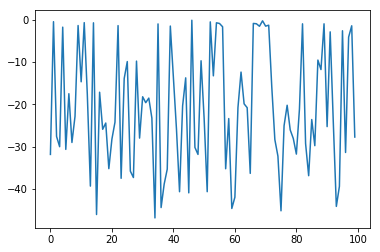

In [24]:
plt.plot(average_rewards)
plt.show()

In [26]:
env = gym.make(ENV_NAME)
env = DummyVecEnv([lambda: env])
model = PPO2(MlpPolicy, env, verbose=1)
model.learn(100)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
--------------------------------------
| approxkl           | 9.4723895e-05 |
| clipfrac           | 0.0           |
| ep_rewmean         | nan           |
| eplenmean          | nan           |
| explained_variance | -0.000188     |
| fps                | 191           |
| nupdates           | 1             |
| policy_entropy     | 2.836264      |
| policy_loss        | -0.0014905145 |
| serial_timesteps   | 128           |
| time_elapsed       | 4.53e-06      |
| total_timesteps    | 128           |
| value_loss         | 724.592       |
--------------------------------------


In [34]:
# test model
env = gym.make(ENV_NAME)
obs = env.reset()
total_reward = 0
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    total_reward += rewards
    
print(total_reward)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
-11.344475038536892
